# Virtualizarr v2.x minimal test

Using NASA Earthdata dataset `MUR25-JPL-L4-GLOB-v04.2` (required access creds). Basic L4 data structure.

In [1]:
# Built-in packages-----------------
import os
import sys
import shutil

# Filesystem management-----------------
import earthaccess

import fsspec

from obstore.auth.earthdata import NasaEarthdataCredentialProvider
from obstore.store import S3Store
from obspec_utils.registry import ObjectStoreRegistry

# Data handling-----------------
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
from virtualizarr.parsers import HDFParser
import pandas as pd

# Parallel computing -----------------
# import multiprocessing
# from dask import delayed
# import dask.array as da
# from dask.distributed import Client
# import coiled

# Other-----------------
import matplotlib.pyplot as plt

## 1. Get Data File S3 endpoints in Earthdata Cloud

In [2]:
# Get Earthdata creds
auth = earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [3]:
# Locate file information / metadata:
shortname = "MUR25-JPL-L4-GLOB-v04.2"
granule_info = earthaccess.search_data(
    short_name=shortname,
    )

In [4]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print("Number of granules found =", len(data_s3links))
print("First few granules:")
data_s3links[0:5]

Number of granules found = 8557
First few granules:


['s3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20020901090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20020902090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20020903090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20020904090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc',
 's3://podaac-ops-cumulus-protected/MUR25-JPL-L4-GLOB-v04.2/20020905090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc']

## 2. Generate single-day reference files

One file per day.

In [5]:
credentials_url = "https://archive.podaac.earthdata.nasa.gov/s3credentials"
bucket = "s3://podaac-ops-cumulus-protected"

In [6]:
credential_provider = NasaEarthdataCredentialProvider(credentials_url, auth=(auth.username, auth.password))
store = S3Store.from_url(bucket, credential_provider=credential_provider)
registry = ObjectStoreRegistry({bucket: store})

In [ ]:
%%time

virtual_ds_list = []

for s3l in data_s3links[:100]:
    vds_ref_single = open_virtual_dataset(
        s3l,
        parser=HDFParser(),
        registry=registry,
        loadable_variables=['lat', 'lon', 'time'],
        decode_times=False
    )
    virtual_ds_list.append(vds_ref_single)

***Output from the above code block was removed due to a lot of warnings about Zarr 3 and codecs***

## 3. Generate combined reference file

## 3.1 Kerchunk JSON

In [9]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(
    virtual_ds_list, concat_dim=['time'], coords='minimal', 
    compat='override', combine_attrs='drop_conflicts'
)

CPU times: user 65.8 ms, sys: 1.86 ms, total: 67.7 ms
Wall time: 66.8 ms


/opt/coiled/env/lib/python3.13/site-packages/zarr/codecs/numcodecs/_codecs.py:141: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


In [10]:
# Save in JSON or PARQUET format:
fname_combined_json = shortname + "_virtual_s3" + ".json"
virtual_ds_combined.vz.to_kerchunk(fname_combined_json, format='json')

## 3.2 Icechunk store

In [13]:
import icechunk

In [ ]:
# you need to explicitly grant permissions to icechunk to read from the locations of your archival files
# we use `anonymous=True` because this is a public bucket, otherwise you need to set credentials explicitly
config = icechunk.RepositoryConfig.default()
config.set_virtual_chunk_container(
    icechunk.VirtualChunkContainer(
        url_prefix=bucket+"/",
        store=icechunk.s3_store(region="us-west-2", anonymous=True),
    ),
)

# create an in-memory icechunk repository that includes the virtual chunk containers
storage = icechunk.in_memory_storage()
repo = icechunk.Repository.create(storage, config)

# open a writable icechunk session to be able to add new contents to the store
session = repo.writable_session("main")

# write the virtual dataset to the session's IcechunkStore instance, using VirtualiZarr's `.vz` accessor
vds1.vz.to_icechunk(session.store)

# commit your changes so that they are permanently available as a new snapshot
snapshot_id = session.commit("Wrote first dataset")
print(snapshot_id)

# optionally persist the new permissions to be permanent, which you probably want
# otherwise every user who wants to read the referenced virtual data back later will have to repeat the `config.set_virtual_chunk_container` step at read time.
repo.save_config()

## 4. Test combined reference file

## 4.1 Using fsspec

In [80]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [81]:
def opends_withref_vz2(ref, fs_data):
    """
    "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
    access the actual data files. 
    """
    storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    m = fs_ref.get_mapper('')
    data = xr.open_dataset(
        m, engine="kerchunk", chunks={},
    )
    return data

In [82]:
%%time
data = opends_withref_vz2(fname_combined_json, fs)
data

CPU times: user 12.1 s, sys: 1.29 s, total: 13.4 s
Wall time: 2min 45s


<xarray.Dataset> Size: 14GB
Dimensions:           (time: 365, lat: 720, lon: 1440)
Coordinates:
  * lat               (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * lon               (lon) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time              (time) datetime64[ns] 3kB 2002-09-01T09:00:00 ... 2003-...
Data variables:
    analysed_sst      (time, lat, lon) float64 3GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    mask              (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 3GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/46)
    Conventions:                CF-1.7, ACDD-1.3
    title:                      Daily 0.25-degree MUR SST, Final product
    summary:                    A low-resolution version of the MUR SST analy...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              https://www.ghrsst.org
    publisher_email:            gpc@ghrsst.org
    file_quality_level:         3
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    acknowledgment:             Please acknowledge the use of these data with...

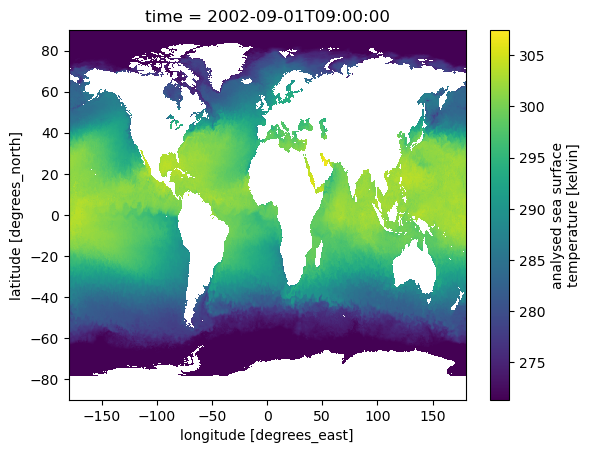

In [59]:
data["analysed_sst"].isel(time=0).plot()

In [65]:
t11 = np.datetime64("2003-01-01T09:00:00")
t12 = np.datetime64("2003-04-01T09:00:00")
t21 = np.datetime64("2003-04-01T09:00:00")
t22 = np.datetime64("2003-08-01T09:00:00")

In [66]:
sst_meanmap1 = data["analysed_sst"].sel(time=slice(t11,t12)).mean(dim="time").compute()
sst_meanmap2 = data["analysed_sst"].sel(time=slice(t21,t22)).mean(dim="time").compute()

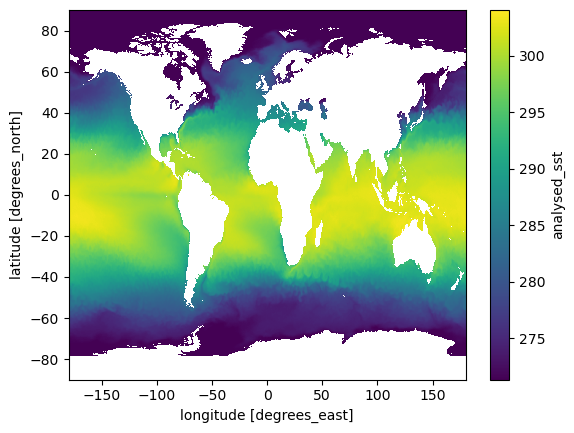

In [67]:
sst_meanmap1.plot()

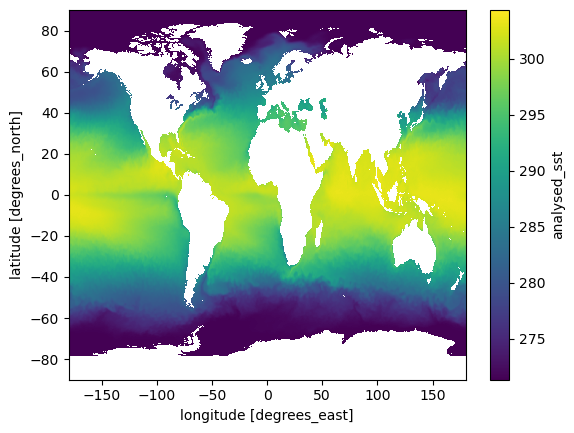

In [68]:
sst_meanmap2.plot()

## 4.2 Using obstore

In [ ]:
result = obstore.get(store, filename)